In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
import copy
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, l

In [3]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')
from func import get_fdr_p_df, corr_pred_true, get_reg, get_stratified_cv, run_reg_scv, update_progress, cross_val_score_nuis

In [4]:
exclude_str = 't1Exclude'
extra_str = '_consist' # '_vol_norm' '_noboxcox' '_consist'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_scale = 200
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                                        parc_scale = parc_scale,
                                                                                       extra_str = extra_str, edge_weight = edge_weight)

In [5]:
os.environ['MODELDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount_consist'

In [6]:
predictiondir = os.path.join(os.environ['MODELDIR'], 'predict_pheno')
predictiondir

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount_consist/predict_pheno'

In [7]:
metrics = ['vol', 'str', 'ac', 'mc']
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
phenos_short = ['Ov. Psy.','Psy. (pos)','Psy. (neg)','Anx. Mis.','Ext.','Fear']

algs = ['rr', 'lr', 'krr_lin', 'krr_rbf', 'svr_rbf']
scores = ['r2', 'corr', 'mse']
seeds = np.arange(0,100)

In [8]:
a = 3; alg = algs[a]; print(alg)
score = 'mse'; print(score)

m = 2; metric = metrics[m]; print(metric)
p = 3; pheno = phenos[p]; print(pheno)
# print(scv_score[m,p])
# print(scv_alpha[m,p])
# print(scv_gamma[m,p])

krr_rbf
mse
ac
AnxiousMisery


## Setup plots

In [9]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = sns.color_palette("pastel", 3)

## Load data

In [10]:
df_node = pd.read_csv(os.path.join(predictiondir, 'X.csv'))
# df_node = pd.read_csv(os.path.join(predictiondir, 'X_wins.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

# df_pheno = pd.read_csv(os.path.join(predictiondir, 'y.csv'))
# df_pheno.set_index(['bblid', 'scanid'], inplace = True)

# covariates
df_pheno = pd.read_csv(os.path.join(os.environ['MODELDIR'], 'df_pheno.csv'))
df_pheno.set_index(['bblid', 'scanid'], inplace = True)

In [11]:
df_node.head()

,,vol_0,vol_1,vol_2,vol_3,vol_4,vol_5,vol_6,vol_7,vol_8,vol_9,...,mc_190,mc_191,mc_192,mc_193,mc_194,mc_195,mc_196,mc_197,mc_198,mc_199
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,5189.0,2500.0,2724.0,2812.0,3148.0,3396.0,2501.0,1817.0,843.0,4791.0,...,0.959763,0.844990,0.927408,0.968814,0.994395,0.971797,0.966033,0.992555,0.982908,0.990543
80680,2739,6030.0,4159.0,4376.0,3968.0,4736.0,4269.0,4102.0,3579.0,1518.0,7330.0,...,0.935903,0.873835,0.652250,0.784366,0.943377,0.918424,0.936248,0.977202,0.932814,0.975621
81754,2740,5426.0,3135.0,4029.0,3247.0,4108.0,3276.0,2612.0,2754.0,741.0,5818.0,...,0.907625,0.983894,0.931573,0.913933,0.976324,0.969865,0.986134,0.997702,0.984583,0.995968
81903,2749,3173.0,2491.0,2027.0,2494.0,2450.0,3164.0,2554.0,1617.0,664.0,3197.0,...,0.949130,0.983709,0.896786,0.953799,0.982359,0.958171,0.973325,0.996257,0.983886,0.994039
81043,2750,3327.0,1890.0,2183.0,2525.0,3189.0,2660.0,2451.0,1758.0,871.0,3532.0,...,0.874115,0.981286,0.837727,0.952593,0.991303,0.967862,0.978795,0.995378,0.971681,0.986653


In [12]:
X = df_node.filter(regex = metric); print(X.shape)
y = df_pheno.loc[:,pheno]

(1062, 200)


In [13]:
# covs = ['ageAtScan1', 'sex', 'averageManualRating']
covs = ['ageAtScan1', 'sex', 'mprage_antsCT_vol_TBV', 'dti64MeanRelRMS', 'network_density']
c = df_pheno.loc[:,covs]

In [14]:
if score == 'r2':
    my_scorer = make_scorer(r2_score, greater_is_better = True)
elif score == 'corr':
    my_scorer = make_scorer(corr_pred_true, greater_is_better = True)
elif score == 'mse':
    my_scorer = make_scorer(mean_squared_error, greater_is_better = False)
my_scorer

make_scorer(mean_squared_error, greater_is_better=False)

In [15]:
# scv_score = np.load(os.path.join(predictiondir, 'stratified_null', score, 'accuracy.npy'))

In [16]:
# scv_score[a,m,p]

In [17]:
regs, param_grids = get_reg()

In [18]:
n_splits = 10
grid = run_reg_scv(X = X, y = y, reg = regs[alg], param_grid = param_grids[alg], scoring = my_scorer, n_splits = n_splits)

In [19]:
main_score = grid.best_score_
main_sterr = grid.cv_results_['std_test_score'][grid.best_index_] / np.sqrt(n_splits)

In [20]:
print(main_score)
print(main_sterr)
print(grid.best_params_)

-0.9898524652451804
0.016325653220659587
{'reg__alpha': 0.001, 'reg__gamma': 1.0}


In [21]:
reg = copy.deepcopy(regs[alg])
reg.alpha = grid.best_params_['reg__alpha']
reg.gamma = grid.best_params_['reg__gamma']
pipe = Pipeline(steps=[('standardize', StandardScaler()),
                       ('reg', reg)])
print(pipe)

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=1.0,
                             kernel='rbf', kernel_params=None))],
         verbose=False)


In [22]:
X_sort, y_sort, my_cv, c_sort = get_stratified_cv(X = X, y = y, c = c, n_splits = n_splits)

In [23]:
nuis_model = cross_val_score_nuis(X = X_sort, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
main_score_nuis = nuis_model.mean()
main_sterr_nuis = nuis_model.std() / np.sqrt(n_splits)

In [24]:
print(main_score)
print(main_sterr)

-0.9898524652451804
0.016325653220659587


### Gradient model

In [25]:
cross_val_score(pipe, X = X_sort, y = y_sort, cv = my_cv, scoring = my_scorer).mean()

-0.9898524652451804

In [26]:
gradient = np.loadtxt(os.path.join(os.environ['MODELDIR'],'pnc_grads_template.txt'))[:,0]

In [27]:
bin_size = 5
compute_null = True
use_nuis = True

# sort gradient
sort_idx = np.argsort(gradient)

# reorder X
X_sort_grad = X_sort.iloc[:,sort_idx]

# compute accuracy for non overlapping windows
print('Computing accuracy for non overlapping windows')
window_start = np.arange(0,num_parcels - bin_size + 1, bin_size)
num_windows = len(window_start)

window_score = np.zeros(num_windows,)
window_sterr = np.zeros(num_windows,)

for i, w in enumerate(window_start):
    Xl = X_sort_grad.iloc[:,w:w+bin_size]
    if use_nuis: cv_results = cross_val_score_nuis(X = Xl, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
    else: cv_results = cross_val_score(pipe, X = Xl, y = y_sort, cv = my_cv, scoring = my_scorer)
    window_score[i] = cv_results.mean()
    window_sterr[i] = cv_results.std() / np.sqrt(n_splits)

# compute accuracy for overlapping windows
print('Computing accuracy for overlapping windows')
step_size = 1
window_start = np.arange(0,num_parcels - bin_size + 1, step_size)
num_windows = len(window_start)

window_score_overlap = np.zeros(num_windows,)
window_sterr_overlap = np.zeros(num_windows,)

for i, w in enumerate(window_start):
    Xl = X_sort_grad.iloc[:,w:w+bin_size]
    if use_nuis: cv_results = cross_val_score_nuis(X = Xl, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
    else: cv_results = cross_val_score(pipe, X = Xl, y = y_sort, cv = my_cv, scoring = my_scorer)
    window_score_overlap[i] = cv_results.mean()
    window_sterr_overlap[i] = cv_results.std() / np.sqrt(n_splits)

# compute null using random samples of regions
if compute_null:
    print('Computing null accuracy')
    random_score = np.zeros(num_windows,)
    random_sterr = np.zeros(num_windows,)
    np.random.seed(0)

    for i, w in enumerate(window_start):
        Xl = X_sort_grad.sample(frac = bin_size/num_parcels, axis = 1)
        if use_nuis: cv_results = cross_val_score_nuis(X = Xl, y = y_sort, c = c_sort, my_cv = my_cv, reg = reg, my_scorer = my_scorer)
        else: cv_results = cross_val_score(pipe, X = Xl, y = y_sort, cv = my_cv, scoring = my_scorer)
        random_score[i] = cv_results.mean()
        random_sterr[i] = cv_results.std() / np.sqrt(n_splits)

Computing accuracy for non overlapping windows
Computing accuracy for overlapping windows
Computing null accuracy


Text(0.5, 1.0, 'GAM: p-val: 0.0122\n GAM (null): p-val: 0.5354')

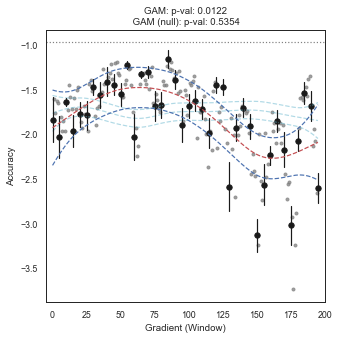

In [28]:
# plot
f, ax = plt.subplots()
f.set_figwidth(5)
f.set_figheight(5)

window_start = np.arange(0,num_parcels - bin_size + 1, step_size)
# gradient null model
if compute_null:
    # plt.scatter(x = window_start, y = window_score_random, color = 'c', s = 10, alpha = 0.5)
    gam_null = LinearGAM(s(0), n_splines = 12).fit(window_start, random_score)
    XX = gam_null.generate_X_grid(term=0, n=num_parcels)
    plt.plot(XX, gam_null.predict(XX), color='c', ls='--', alpha = 0.5)
    plt.plot(XX, gam_null.confidence_intervals(XX, width=.95), color='c', ls='--', alpha = 0.5)

# overlapping sliding windows scatter
plt.scatter(x = window_start, y = window_score_overlap, color = 'gray', s = 10, alpha = 0.75)

# full brain model score
if use_nuis: ax.axhline(y = main_score_nuis, color = 'gray', linestyle = ':')
else: ax.axhline(y = main_score, color = 'gray', linestyle = ':')

# ax.axhline(y = main_score - std_error, color = 'black', linestyle = ':')
# ax.axhline(y = main_score + std_error, color = 'black', linestyle = ':')

# non overlapping windows
window_start = np.arange(0,num_parcels - bin_size + 1, bin_size)
# x_marks = np.arange(0, num_parcels, bin_size)
if len(window_start) > len(window_score): window_start = window_start[:len(window_score)]
plt.scatter(x = window_start, y = window_score, color = 'k', s = 30)

# main GAM
gam = LinearGAM(s(0), n_splines = 12).fit(window_start, window_score)
for i, j in enumerate(window_start): plt.plot([j, j], [window_score[i]-window_sterr[i], window_score[i]+window_sterr[i]], color = 'k')
XX = gam.generate_X_grid(term=0, n=num_parcels)
plt.plot(XX, gam.predict(XX), color='r', ls='--')
plt.plot(XX, gam.confidence_intervals(XX, width=0.95), color='b', ls='--')

ax.set_xlabel('Gradient (Window)')
ax.set_ylabel('Accuracy')
ax.set_xlim([-bin_size, num_parcels])

ax.set_title('GAM: p-val: '+ str(np.round(gam.statistics_['p_values'][0],4)) + \
            '\n GAM (null): p-val: '+ str(np.round(gam_null.statistics_['p_values'][0],4)))
# ax.set_title('GAM: p-val: '+ str(np.round(gam.statistics_['p_values'][0],4)) + \
#             '\n Spearman Rank: ' + str(np.round(sp.stats.spearmanr(window_start, window_score),4)[0]) + \
#              ', p-val: ' + str(np.round(sp.stats.spearmanr(window_start, window_score),4)[1]))